In [1]:
import sys
sys.path.append("../LocalGraphClustering/")
import localgraphclustering as lgc
from localgraphclustering.find_clusters import semisupervised_learning_with_improve,semisupervised_learning
from collections import Counter,defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Citeseer dataset

In [125]:
rptr = open("dataset/citeseer/citeseer.content","r")
lines = rptr.readlines()
rptr.close()

ids = {}
labels = {}
clusters = defaultdict(list)
nnodes = 0
for i,line in enumerate(lines):
    tmp = line.replace("\n","").split("\t")
    labels[i] = tmp[-1]
    ids[tmp[0]] = i
    nnodes += 1
    clusters[tmp[-1]].append(i)

rptr = open("dataset/citeseer/citeseer.cites","r")
lines = rptr.readlines()
rptr.close()

ei,ej = [],[]
for line in lines:
    tmp = line.replace("\n","").split("\t")
    if tmp[0] not in ids:
        ids[tmp[0]] = nnodes
        nnodes += 1
    if tmp[1] not in ids:
        ids[tmp[1]] = nnodes
        nnodes += 1
    ei.append(ids[tmp[0]])
    ej.append(ids[tmp[1]])

g = lgc.GraphLocal()
g.list_to_gl(ei,ej,[1.0]*len(ei))
g.connected_components()
largest_component= set(np.nonzero(g.components == Counter(g.components).most_common()[0][0])[0])
g_copy = g.largest_component()
clusters_copy = defaultdict(list)
nnodes = 0
for i in range(g._num_vertices):
    if i in largest_component:
        if i in labels:
            clusters_copy[labels[i]].append(nnodes)
        nnodes += 1

There are  438  connected components in the graph
There are  438  connected components in the graph


## semi-supervised learning using subset of target cluster as seed nodes

In [126]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":1.0e-10,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-8,
                "iterations":100000,
                "cpp":True,
                "delta":0.0001,
                "ratio":ratio} for ratio in 0.01*np.array(range(5,26))]

In [127]:
records = semisupervised_learning(g_copy,clusters_copy,kwargs_list,nprocs=21)

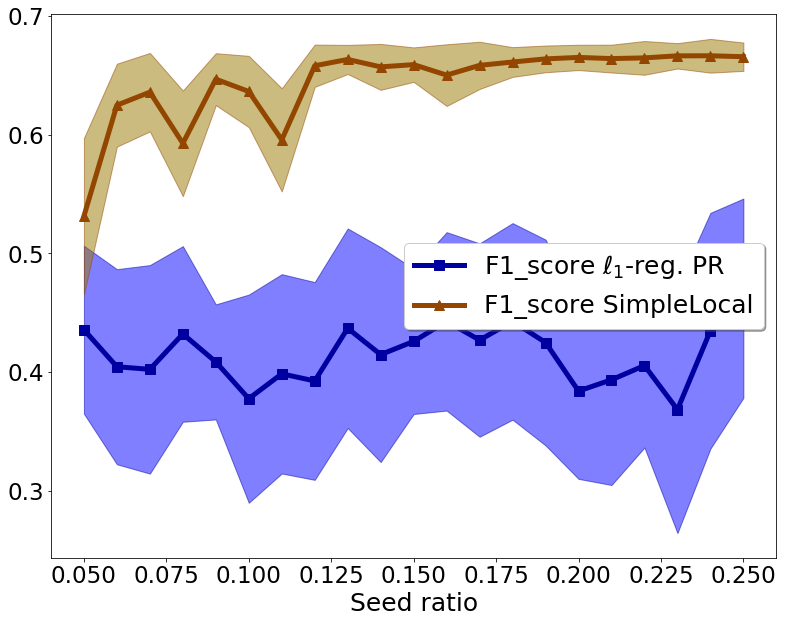

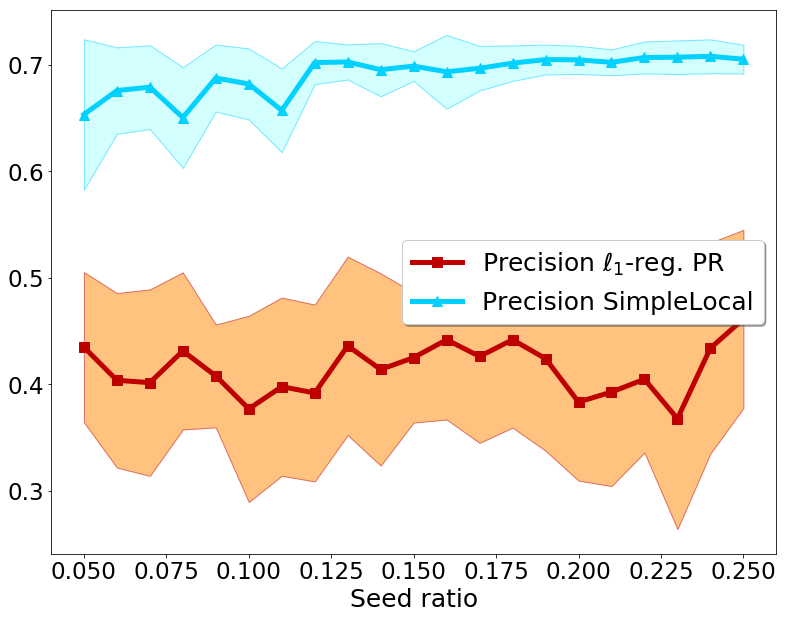

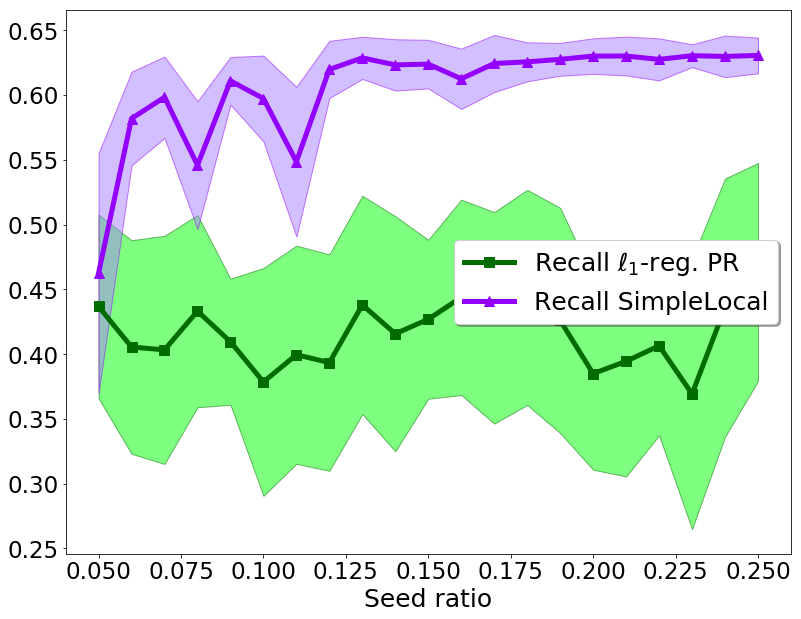

In [129]:
x = 0.01*np.array(range(5,26))
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["sl_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["sl_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["sl_RC_all"]])
std1 = np.array([i[1] for i in records["l1reg_F1_all"]])
std2 = np.array([i[1] for i in records["sl_F1_all"]])
std3 = np.array([i[1] for i in records["l1reg_PR_all"]])
std4 = np.array([i[1] for i in records["sl_PR_all"]])
std5 = np.array([i[1] for i in records["l1reg_RC_all"]])
std6 = np.array([i[1] for i in records["sl_RC_all"]])

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y1-std1, y1+std1,
    alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y2-std2, y2+std2,
    alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='center right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_f1_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y3-std3, y3+std3,
    alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y4-std4, y4+std4,
    alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='center right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_pr_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y5-std5, y5+std5,
    alpha=0.5, edgecolor='#006C00', facecolor='#00FF00')
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y6-std6, y6+std6,
    alpha=0.5, edgecolor='#9400FF', facecolor='#A780FF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='center right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("citeseer_rc_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

# Cora citation dataset

In [121]:
import sys
sys.path.append("../LocalGraphClustering/")
import localgraphclustering as lgc
from collections import Counter,defaultdict
import numpy as np

rptr = open("dataset/cora/cora.content","r")
lines = rptr.readlines()
rptr.close()

ids = {}
labels = {}
clusters = defaultdict(list)
nnodes = 0
for i,line in enumerate(lines):
    tmp = line.replace("\n","").split("\t")
    labels[i] = tmp[-1]
    ids[tmp[0]] = i
    nnodes += 1
    clusters[tmp[-1]].append(i)

rptr = open("dataset/cora/cora.cites","r")
lines = rptr.readlines()
rptr.close()

ei,ej = [],[]
for line in lines:
    tmp = line.replace("\n","").split("\t")
    if tmp[0] not in ids:
        ids[tmp[0]] = nnodes
        nnodes += 1
    if tmp[1] not in ids:
        ids[tmp[1]] = nnodes
        nnodes += 1
    ei.append(ids[tmp[0]])
    ej.append(ids[tmp[1]])

g = lgc.GraphLocal()
g.list_to_gl(ei,ej,[1.0]*len(ei))
g.connected_components()
largest_component= set(np.nonzero(g.components == Counter(g.components).most_common()[0][0])[0])
g_copy = g.largest_component()
clusters_copy = defaultdict(list)
nnodes = 0
for i in range(g._num_vertices):
    if i in largest_component:
        if i in labels:
            clusters_copy[labels[i]].append(nnodes)
        nnodes += 1

There are  78  connected components in the graph
There are  78  connected components in the graph


../LocalGraphClustering/localgraphclustering/GraphLocal.py:621: UserWarning:

The graph has multiple (78) components, using the largest with 2485 / 2708 nodes



## semi-supervised learning using subset of target cluster as seed nodes

In [122]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":1.0e-10,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-8,
                "iterations":100000,
                "cpp":True,
                "delta":0.0001,
                "ratio":ratio} for ratio in 0.01*np.array(range(5,26))]

In [123]:
records = semisupervised_learning(g_copy,clusters_copy,kwargs_list,nprocs=21)

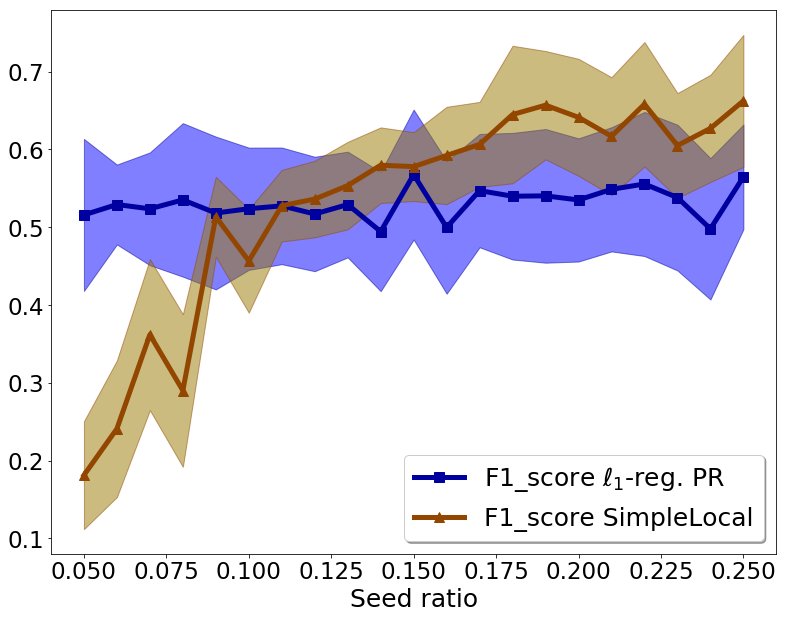

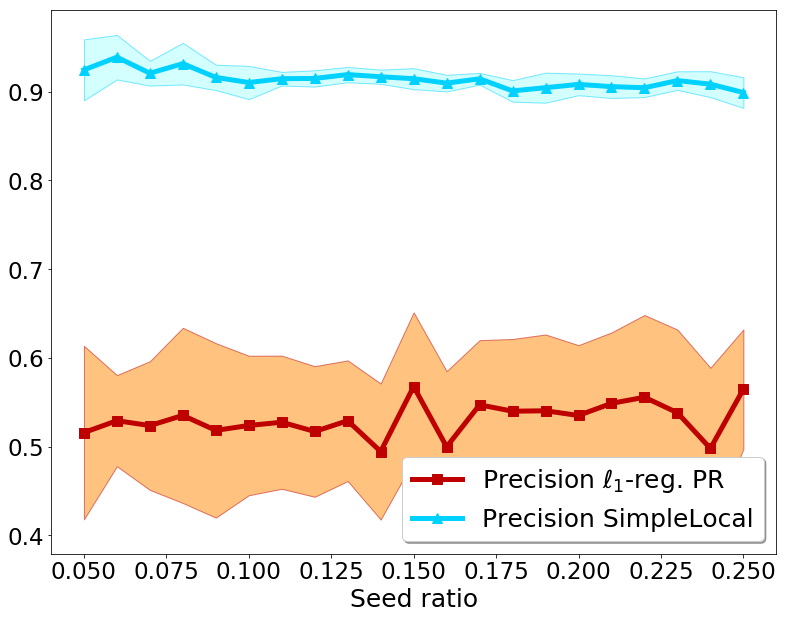

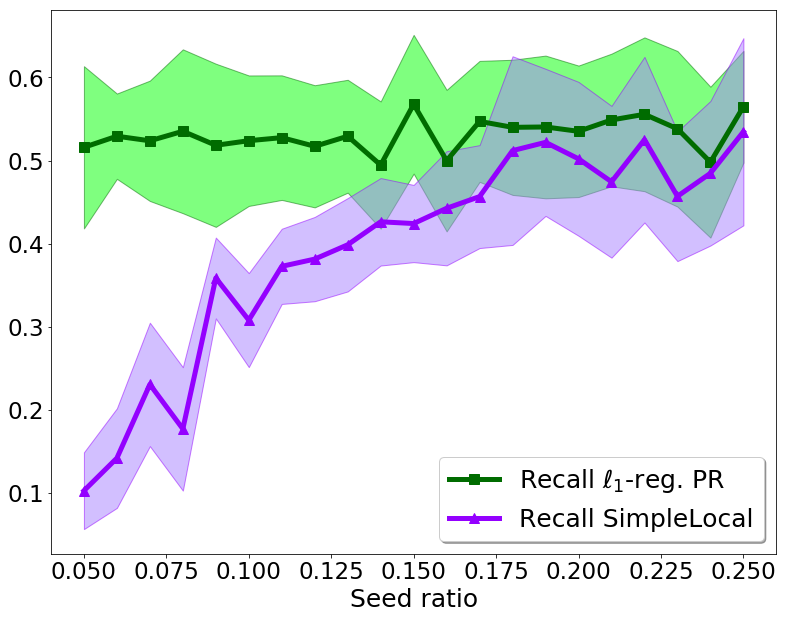

In [124]:
x = 0.01*np.array(range(5,26))
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["sl_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["sl_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["sl_RC_all"]])
std1 = np.array([i[1] for i in records["l1reg_F1_all"]])
std2 = np.array([i[1] for i in records["sl_F1_all"]])
std3 = np.array([i[1] for i in records["l1reg_PR_all"]])
std4 = np.array([i[1] for i in records["sl_PR_all"]])
std5 = np.array([i[1] for i in records["l1reg_RC_all"]])
std6 = np.array([i[1] for i in records["sl_RC_all"]])


# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y1-std1, y1+std1,
    alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y2-std2, y2+std2,
    alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("cora_f1_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y3-std3, y3+std3,
    alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y4-std4, y4+std4,
    alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("cora_pr_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y5-std5, y5+std5,
    alpha=0.5, edgecolor='#006C00', facecolor='#00FF00')
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y6-std6, y6+std6,
    alpha=0.5, edgecolor='#9400FF', facecolor='#A780FF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("cora_rc_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

# MNIST knn network

In [4]:
import numpy as np
import mnist
import scipy.misc

images = mnist.train_images()
labels = mnist.train_labels()

In [5]:
image_data = np.zeros((images.shape[0],images.shape[1]*images.shape[2]),dtype=np.float32)

In [6]:
for i,im in enumerate(images):
    image_data[i,:] = (im.astype("float32")/255).flatten()

In [2]:
import pickle
import scipy.sparse as sp
rptr = open("dataset/MNIST_100_knn.p","rb")
A = pickle.load(rptr)
rptr.close()

sel = A.T > A
A = A - A.multiply(sel) + A.T.multiply(sel)

In [7]:
g = lgc.GraphLocal.from_sparse_adjacency(A)
clusters = defaultdict(list)
for i,l in enumerate(labels):
    clusters[l].append(i)
g.connected_components()
largest_component= set(np.nonzero(g.components == Counter(g.components).most_common()[0][0])[0])
g_copy = g.largest_component()
clusters_copy = defaultdict(list)
nnodes = 0
for i in range(g._num_vertices):
    if i in largest_component:
        clusters_copy[labels[i]].append(nnodes)
        nnodes += 1

There are  1  connected components in the graph
There are  1  connected components in the graph


## semi-supervised learning using subset of target cluster as seed nodes

In [110]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":1.0e-5,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-3,
                "iterations":10000,
                "cpp":True,
                "delta":0.1,
                "ratio":ratio} for ratio in 0.01*np.array(range(5,26))]

In [111]:
records = semisupervised_learning(g_copy,clusters_copy,kwargs_list,nprocs=21)
# wptr = open("MNIST_ssl_sl.p","wb")
# pickle.dump(records,wptr)
# wptr.close()

TypeError: Pickling an AuthenticationString object is disallowed for security reasons

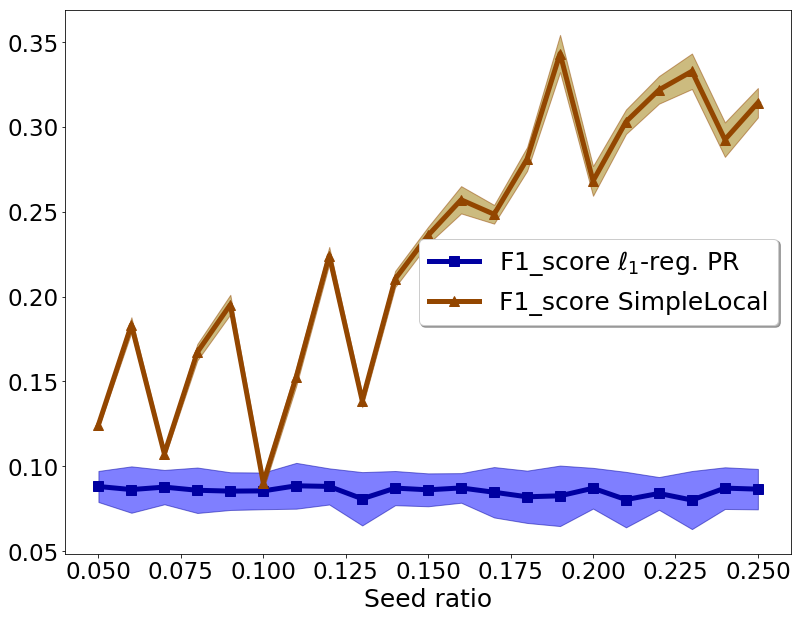

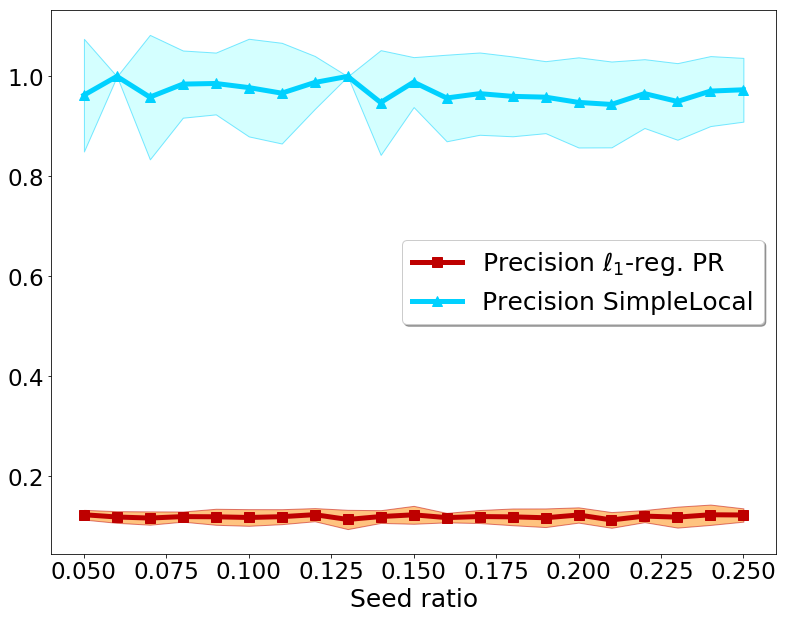

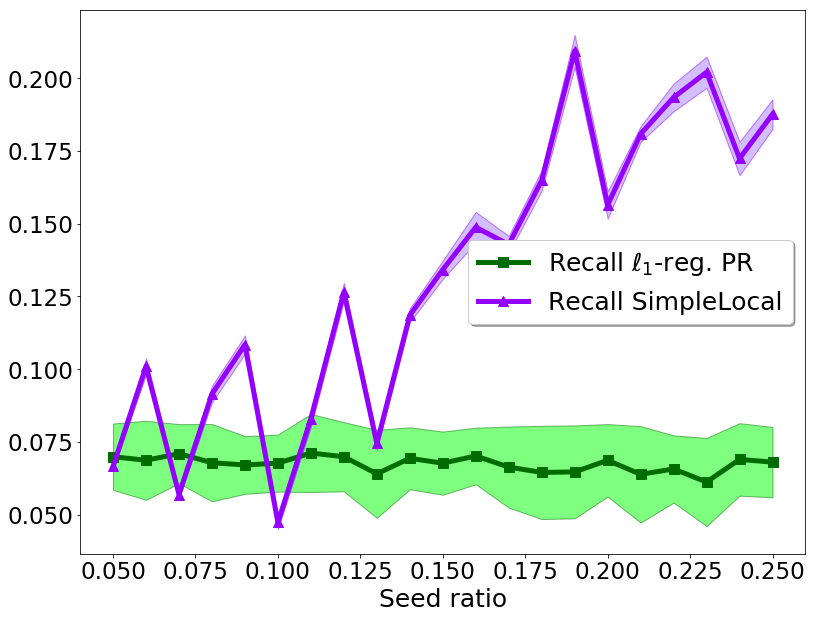

In [116]:
x = 0.01*np.array(range(5,26))
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["sl_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["sl_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["sl_RC_all"]])
std1 = np.array([i[1] for i in records["l1reg_F1_all"]])
std2 = np.array([i[1] for i in records["sl_F1_all"]])
std3 = np.array([i[1] for i in records["l1reg_PR_all"]])
std4 = np.array([i[1] for i in records["sl_PR_all"]])
std5 = np.array([i[1] for i in records["l1reg_RC_all"]])
std6 = np.array([i[1] for i in records["sl_RC_all"]])

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y1-std1, y1+std1,
    alpha=0.5, edgecolor='#0000A1', facecolor='#0000FF')
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y2-std2, y2+std2,
    alpha=0.5, edgecolor='#934600', facecolor='#9B7900')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='center right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("mnist_f1_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y3-std3, y3+std3,
    alpha=0.5, edgecolor='#BE0000', facecolor='#FF8800')
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y4-std4, y4+std4,
    alpha=0.5, edgecolor='#00D1FF', facecolor='#ABFFFF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='center right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("mnist_pr_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.fill_between(x, y5-std5, y5+std5,
    alpha=0.5, edgecolor='#006C00', facecolor='#00FF00')
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.fill_between(x, y6-std6, y6+std6,
    alpha=0.5, edgecolor='#9400FF', facecolor='#A780FF')
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='center right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f.savefig("mnist_rc_sl_without_l1reg.pdf",format='pdf',bbox_inches='tight')

In [99]:
kwargs = {"method":"l1reg-rand",
                "alpha":0.1,
                "rho":1.0e-5,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-3,
                "iterations":10000,
                "cpp":True}
label = 2
truth = clusters_copy[label]
ratio = 0.1
nseeds = int(ratio*len(truth))
seeds = np.random.choice(truth,nseeds)
l1reg_ids,l1reg_vals = lgc.approximate_PageRank(g_copy,seeds,**kwargs)

In [100]:
len(l1reg_ids)

32768

In [101]:
len(seeds)

595

In [102]:
len(set(l1reg_ids).intersection(truth))

4904

In [103]:
len(truth)

5958

In [115]:
wptr = open("MNIST_ssl_sl.p","wb")
pickle.dump(records,wptr)
wptr.close()

In [109]:
records

{'output': (0.14044520747073355,
  0.027558396815065736,
  0.08513166666666667,
  0.019805999301558432,
  0.10575988001672518,
  0.022539238470275575,
  0.9307764168550603,
  0.08483898242348852,
  0.19389249999999997,
  0.005643269036353543,
  0.320539954912515,
  0.010041674541355981),
 'ncounts': 21,
 'p': <Process(Process-21, stopped)>,
 'procs': [<Process(Process-1, stopped)>,
  <Process(Process-2, stopped)>,
  <Process(Process-3, stopped)>,
  <Process(Process-4, stopped)>,
  <Process(Process-5, stopped)>,
  <Process(Process-6, stopped)>,
  <Process(Process-7, stopped)>,
  <Process(Process-8, stopped)>,
  <Process(Process-9, stopped)>,
  <Process(Process-10, stopped)>,
  <Process(Process-11, stopped)>,
  <Process(Process-12, stopped)>,
  <Process(Process-13, stopped)>,
  <Process(Process-14, stopped)>,
  <Process(Process-15, stopped)>,
  <Process(Process-16, stopped)>,
  <Process(Process-17, stopped)>,
  <Process(Process-18, stopped)>,
  <Process(Process-19, stopped)>,
  <Process(

In [112]:
wptr = open("MNIST_ssl_sl.p","wb")
pickle.dump(records,wptr)
wptr.close()

TypeError: Pickling an AuthenticationString object is disallowed for security reasons

In [113]:
records.keys()

dict_keys(['output', 'ncounts', 'p', 'procs', '_', 'kwargs', 'sl_F1_all', 'sl_RC_all', 'sl_PR_all', 'l1reg_F1_all', 'l1reg_RC_all', 'l1reg_PR_all', 'nprocs', 'kwargs_list', 'wrapper', 'truth_dict', 'q_out', 'q_in', 'g'])

In [114]:
del records["p"]
del records["output"]
del records["ncounts"]
del records["procs"]
del records["_"]
del records["kwargs"]
del records["q_in"]
del records["q_out"]
del records["wrapper"]